# Bayesian histogram demo

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
sns.set()

from bayeshist import bayesian_histogram, plot_bayesian_histogram

np.random.seed(17)

## Generate some test data

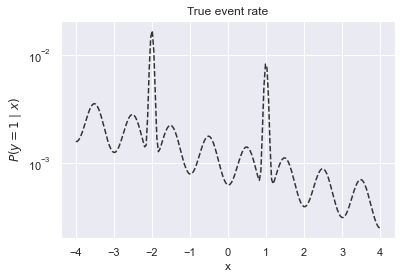

In [20]:
def test_dist(k):
    p = 1 / (1 + 10 ** (3 + 0.1 * (k + 2 * np.cos(2 * np.pi * k))))
    p *= 1 + 2 * scipy.stats.norm(loc=1, scale=0.05).pdf(k)
    p *= 1 + 2 * scipy.stats.norm(loc=-2, scale=0.05).pdf(k)
    return p

plt.plot(x:=np.linspace(-4, 4, 200), test_dist(x), '--', c='0.2')
plt.yscale("log")
plt.xlabel("x")
plt.ylabel("$P(y=1 \\mid x)$")
plt.title("True event rate")
plt.savefig("true-events.png", dpi=150, bbox_inches="tight")

The true event rate is at most ~1%, so this is a rare event! Still, there is a lot of variation in its occurrence rate, so let's see how we can estimate that from samples.

In [21]:
def generate_test_data(n):
    x = scipy.stats.norm().rvs(n)
    return x, np.random.rand(n) < test_dist(x)

In [22]:
test_x, test_y = generate_test_data(1_000_000)

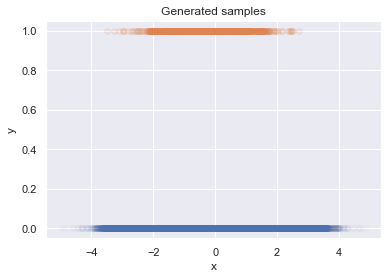

In [23]:
plt.scatter(x:=test_x[test_y == 0], np.zeros_like(x), alpha=0.01)
plt.scatter(x:=test_x[test_y == 1], np.ones_like(x), alpha=0.1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated samples")
plt.savefig("samples.png", dpi=150, bbox_inches="tight")

Now this is what the model sees. At these event rates we can't really tell anything by eyeballing.

## Event rate estimation through histograms

For the simplest estimate, we can look at the normalized histograms of events and non-events:

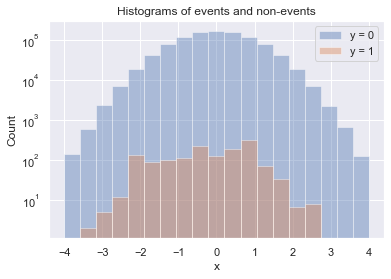

In [24]:
bins = np.linspace(-4, 4, 20)
plt.hist(test_x[test_y == 0], log=True, alpha=0.4, bins=bins, label="y = 0")
plt.hist(test_x[test_y == 1], log=True, alpha=0.4, bins=bins, label="y = 1")
plt.legend()
plt.xlabel("x")
plt.ylabel("Count")
plt.title("Histograms of events and non-events")
plt.savefig("histograms.png", dpi=150, bbox_inches="tight")

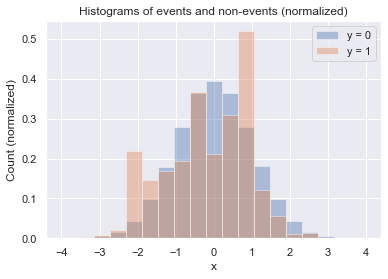

In [25]:
bins = np.linspace(-4, 4, 20)
plt.hist(test_x[test_y == 0], density=True, alpha=0.4, bins=bins, label="y = 0")
plt.hist(test_x[test_y == 1], density=True, alpha=0.4, bins=bins, label="y = 1")
plt.legend()
plt.xlabel("x")
plt.ylabel("Count (normalized)")
plt.title("Histograms of events and non-events (normalized)")
plt.savefig("histograms-normalized.png", dpi=150, bbox_inches="tight")

Looks like there are 3 peaks in the event histogram, but since the non-event histogram varies so much it's hard to tell anything. The ratio of the 2 histograms is more informative:

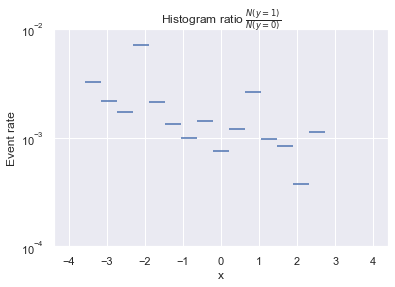

In [26]:
neg_samples, _ = np.histogram(test_x[test_y == 0], bins=bins)
pos_samples, _ = np.histogram(test_x[test_y == 1], bins=bins)

plt.hlines(pos_samples / neg_samples, bins[:-1], bins[1:])

plt.yscale("log")
plt.ylim(1e-4, 1e-2)
plt.title("Histogram ratio $\\frac{N(y=1)}{N(y=0)}$")
plt.xlabel("x")
plt.ylabel("Event rate")
plt.savefig("histogram-rate.png", dpi=150, bbox_inches="tight")

There could be 3 peaks, but it's hard to tell. Also, do we even have enough data to quantify this? How sure can we be of this estimate? What do we do with empty bins?

Bayesian histograms help to answer these questions.

## Histograms with error bars: Bayesian histograms

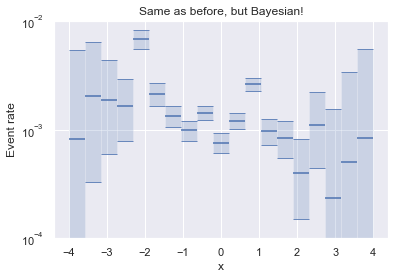

In [27]:
_, data_dist = bayesian_histogram(
    test_x, test_y, 
    bins=bins,
    x_range=(-4, 4),
    pruning_method=None,
)

plot_bayesian_histogram(bins, data_dist)
plt.xlabel("x")
plt.ylabel("Event rate")
plt.yscale("log")
plt.ylim(1e-4, 1e-2)
plt.title("Same as before, but Bayesian!")
plt.savefig("bayesian-histogram-rate.png", dpi=150, bbox_inches="tight")

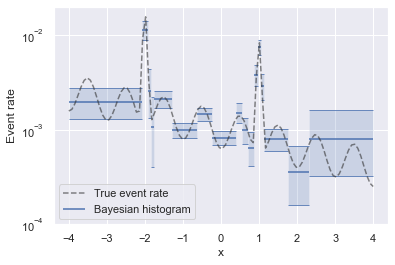

In [28]:
bins, data_dist = bayesian_histogram(
    test_x, test_y, 
    bins=100,
    x_range=(-4, 4),
)

plot_bayesian_histogram(bins, data_dist, label="Bayesian histogram")
plt.plot(x:=np.linspace(-4, 4, 100), test_dist(x), "--", c="0.2", label="True event rate", alpha=0.6)

plt.xlabel("x")
plt.ylabel("Event rate")
plt.yscale("log")
plt.ylim(1e-4, 2e-2)
plt.legend()

plt.savefig("bayesian-histogram-comp.png", dpi=150, bbox_inches="tight")

## Pruned histograms

In [29]:
bins_fisher, data_dist_fisher = bayesian_histogram(
    test_x, test_y, 
    bins=100,
    x_range=(-4, 4),
    pruning_method="fisher",
)
len(bins_fisher)

23

In [30]:
bins_bayes, data_dist_bayes = bayesian_histogram(
    test_x, test_y, 
    bins=100,
    x_range=(-4, 4),
    pruning_method="bayes",
    pruning_threshold=2,
)
len(bins_bayes)

18

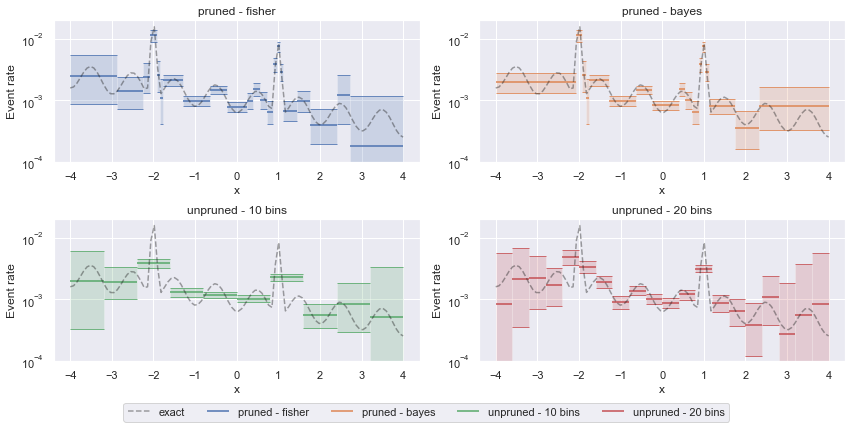

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
(ax1, ax2, ax3, ax4) = axes.flat

plot_bayesian_histogram(bins_fisher, data_dist_fisher, color='C0', label='pruned - fisher', ax=ax1)
ax1.set_title('pruned - fisher')

plot_bayesian_histogram(bins_bayes, data_dist_bayes, color='C1', label='pruned - bayes', ax=ax2)
ax2.set_title('pruned - bayes')

bins_naive, dist_naive = bayesian_histogram(test_x, test_y, bins=10, pruning_method=None, x_range=(-4, 4))
plot_bayesian_histogram(bins_naive, dist_naive, color='C2', label='unpruned - 10 bins', ax=ax3)
ax3.set_title('unpruned - 10 bins')

bins_naive, dist_naive = bayesian_histogram(test_x, test_y, bins=20, pruning_method=None, x_range=(-4, 4))
plot_bayesian_histogram(bins_naive, dist_naive, color='C3', label='unpruned - 20 bins', ax=ax4)
ax4.set_title('unpruned - 20 bins')

for ax in (ax1, ax2, ax3, ax4):
    ax.plot(x:=np.linspace(-4, 4, 100), test_dist(x), '--', c='k', label='exact' if ax is ax1 else None, alpha=0.4)
    ax.set_xlabel("x")
    ax.set_ylabel("Event rate")
    ax.set_yscale("log")
    ax.set_ylim(1e-4, 2e-2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.15)
fig.legend(ncol=5, loc="lower center")
plt.savefig("bayeshist-comparison.png", dpi=150, bbox_inches="tight")

## Compare to optbinning

In [32]:
from optbinning import OptimalBinning

clf = OptimalBinning(max_n_prebins=100, monotonic_trend=None).fit(test_x, test_y)

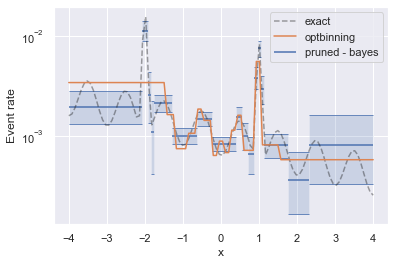

In [33]:
plt.figure()

pred_x = np.linspace(-4, 4, 100)
plt.plot(pred_x, test_dist(pred_x), '--', c='k', label='exact', alpha=0.4)
plt.plot(pred_x, clf.transform(pred_x, metric="event_rate"), c='C1', label='optbinning')

plot_bayesian_histogram(bins_bayes, data_dist_bayes, color='C0', label='pruned - bayes')
plt.legend()
plt.yscale("log")
plt.xlabel("x")
plt.ylabel("Event rate")
plt.savefig("optbinning-comparison.png", dpi=150, bbox_inches="tight")